In [1]:
import tensorflow as tf
if tf.executing_eagerly():
   tf.compat.v1.disable_eager_execution()

In [2]:
import numpy as np
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Flatten, MaxPooling2D
from keras.datasets import mnist
import boto3

s3client = boto3.client('s3')
response = s3client.get_object(Bucket='sagemaker-project-harsh', Key='dataset/train_data.csv')
api_body = response['Body']

/home/ec2-user/anaconda3/envs/amazonei_tensorflow2_p36/lib/python3.6/site-packages/boto3/compat.py:88: PythonDeprecationWarning: Boto3 will no longer support Python 3.6 starting May 30, 2022. To continue receiving service updates, bug fixes, and security updates please upgrade to Python 3.7 or later. More information can be found here: https://aws.amazon.com/blogs/developer/python-support-policy-updates-for-aws-sdks-and-tools/
  warnings.warn(warning, PythonDeprecationWarning)


In [3]:
train = pd.read_csv(api_body)
y_train_df = train['label']
x_train_df = train.iloc[:, 1:]

x_train = np.array(x_train_df)
y_train = np.array(y_train_df)

x_train = x_train.reshape(x_train.shape[0], 28, 28, 1)
x_train.shape
x_train = x_train.astype('float32')
x_train /= 255
print(y_train.shape)
print(y_train[:10])

(60000,)
[5 0 4 1 9 2 1 3 1 4]


In [4]:
from keras.utils import np_utils
y_train = np_utils.to_categorical(y_train, 10)

img_shape=x_train.shape[1:]
img_shape

(28, 28, 1)

In [5]:

model = Sequential()
model.add(Conv2D(28, kernel_size=(3,3), activation = 'relu', input_shape = (28, 28, 1)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(128, activation = 'relu'))
model.add(Dense(10,activation = 'softmax'))

In [6]:
model.compile(optimizer='adam', loss = 'mean_squared_error', metrics=['accuracy'])

In [7]:
model_cnn=model.fit(x_train, y_train, epochs = 5)

Train on 60000 samples
Epoch 1/5
60000/60000 [==============================] - 23s 390us/sample - loss: 0.0074 - accuracy: 0.9514
Epoch 2/5
60000/60000 [==============================] - 22s 372us/sample - loss: 0.0027 - accuracy: 0.9825
Epoch 3/5
60000/60000 [==============================] - 22s 365us/sample - loss: 0.0019 - accuracy: 0.9875
Epoch 4/5
60000/60000 [==============================] - 22s 362us/sample - loss: 0.0014 - accuracy: 0.9913
Epoch 5/5
60000/60000 [==============================] - 22s 359us/sample - loss: 0.0011 - accuracy: 0.9932


Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
8


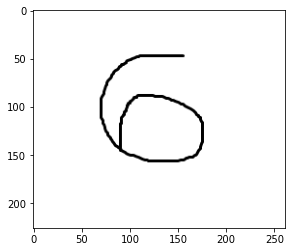

In [9]:
from PIL import Image
import matplotlib.pyplot as plt
    
pred_img = Image.open('number6.png')
plt.imshow(pred_img,cmap='Greys')
re_img = img.resize((28,28))
sh_img = np.array(re_img)
fin_img = sh_img.reshape((-1,28,28,1))

fin_predict = model.predict(fin_img)
print(fin_predict.argmax())

4


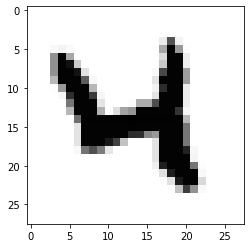

In [10]:
import matplotlib.pyplot as plt

image_index = 20
plt.imshow(x_train[image_index].reshape(28, 28),cmap='Greys')
pred = model.predict(x_train[image_index].reshape(1, 28, 28, 1))
print(pred.argmax())

In [11]:
import os
import tensorflow as tf
from keras.models import model_from_json

!mkdir "cnn_model"
save_path = "./cnn_model/"

model.save_weights(os.path.join(save_path,"model-weights.h5"))

model_json = model.to_json()
with open(os.path.join(save_path,"model_cnn.json"), "w") as json_file:
    json_file.write(model_json)

json_file = open('/home/ec2-user/SageMaker/cnn_model/'+'model_cnn.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json,custom_objects={"GlorotUniform": tf.keras.initializers.glorot_uniform})
loaded_model.load_weights('/home/ec2-user/SageMaker/cnn_model/model-weights.h5')

In [12]:
from tensorflow.python.saved_model import builder
from tensorflow.python.saved_model.signature_def_utils import predict_signature_def
from tensorflow.python.saved_model import tag_constants
import tensorflow

model_version = '1'
export_dir = 'export/Servo/' + model_version

builder = builder.SavedModelBuilder(export_dir)
#builder=tensorflow.compat.v1.saved_model.Builder(export_dir)

signature = predict_signature_def(
    inputs={"inputs": loaded_model.input}, outputs={"score": loaded_model.output})

#from keras import backend as K
session = tf.compat.v1.keras.backend.get_session()
with session as sess:
    builder.add_meta_graph_and_variables(
        sess=sess, tags=[tag_constants.SERVING], signature_def_map={"serving_default": signature})
    builder.save()

Instructions for updating:
This function will only be available through the v1 compatibility library as tf.compat.v1.saved_model.utils.build_tensor_info or tf.compat.v1.saved_model.build_tensor_info.
INFO:tensorflow:No assets to save.
INFO:tensorflow:No assets to write.
INFO:tensorflow:SavedModel written to: export/Servo/1/saved_model.pb


In [13]:
import tarfile
import sagemaker
sagemaker_session = sagemaker.Session()

with tarfile.open('model.tar.gz', mode='w:gz') as archive:
    archive.add('export', recursive=True)

In [14]:
inputs = sagemaker_session.upload_data(path='model.tar.gz', key_prefix='model')

import sagemaker
from sagemaker import get_execution_role
role = get_execution_role()
sagemaker_session = sagemaker.Session()

In [15]:
!touch train.py

In [16]:
from sagemaker.tensorflow.serving import Model
from sagemaker.predictor import csv_serializer
sagemaker_model = Model(framework_version="2.3.1",
                        model_data = 's3://' + sagemaker_session.default_bucket() + '/model/model.tar.gz',
                        role = role,
                        entry_point = 'train.py')

The class sagemaker.tensorflow.serving.Model has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


In [17]:
%%time

cnn_predictor = sagemaker_model.deploy(initial_instance_count=1,instance_type='ml.t2.medium')

update_endpoint is a no-op in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


------!CPU times: user 1.07 s, sys: 78.7 ms, total: 1.15 s
Wall time: 3min 2s


In [18]:
cnn_predictor.endpoint_name

'tensorflow-inference-2022-11-22-23-34-38-828'